Create a Data Pipeline for Training

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

Data settings

In [9]:
IMG_SIZE = 224   # Image size (224x224 pixels)
BATCH_SIZE = 32  # Number of images in each batch
DATASET_DIR = 'dataset_split' 
SEED = 42  #  عشان كل تشغيل يعطي نفس العشوائية

print("Image processor setup...")

Image processor setup...


Setting up ImageDataGenerator for training (with Data Augmentation)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,              #Convert values ​​from 0-255 to 0-1
    rotation_range=15,           # Random rotation ±15 degrees
    width_shift_range=0.1,       # Random horizontal shift 10%
    height_shift_range=0.1,      #Random vertical shift 10%
    brightness_range=[0.8, 1.2], # Change brightness
    horizontal_flip=False,       # Don't flip horizontally
    fill_mode='nearest'          # Fill in the blanks after the flip
)

^^^^
وش سويت:


أنشأت "مصنع للصور" يطبق تغييرات عشوائية على كل صورةليه كل تغيير:rescale=1./255

المشكلة: البكسل قيمته من 0-255 (أرقام كبيرة)
الحل: أقسم على 255 علشان تصير من 0-1
ليه؟ النموذج يتعلم أسرع مع الأرقام الصغيرة
rotation_range=15

الواقع: الناس ما يمسكون اليد بنفس الزاوية دائماً
التطبيق: أدور الصورة عشوائياً ±15 درجة
النتيجة: النموذج يتعرف على الإشارة حتى لو مائلة
width_shift_range=0.1

الواقع: اليد ممكن تكون يمين أو شمال الكادر
التطبيق: أحرك الصورة يمين/شمال 10%
النتيجة: النموذج لا يعتمد على موضع اليد بالضبط
brightness_range=[0.8, 1.2]

الواقع: الإضاءة تختلف (شمس، مصباح، ظل)
التطبيق: أغير سطوع الصورة عشوائياً
النتيجة: يشتغل في أي إضاءة
horizontal_flip=False 

مهم جدا ما أقلب الصورة أفقياً
لان في لغة الإشارة اتجاه اليد مهم جداً
مثال: حرف "د" بيدك اليمنى مختلف عن "د" بيدك اليسرى

Setting up ImageDataGenerator for Validation and Test (without Data Augmentation)

In [11]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

^^^^^ 
وش سويت:
أنشأت "مصنع صور" بسيط بدون تغييرات
ليه:

للـ Validation والـ Test: نبيها زي ما هي بالضبط
ما ابي تغييرات عشوائية: علشان نقيس الأداء الحقيقي
فقط rescale: علشان تكون بنفس مقياس بيانات التدريب

create Data Generators

In [12]:
print("Loading training data..")
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize each image to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',           # Because we have 32 different categories
    color_mode='grayscale',
    shuffle=True,                       # Shuffle the images (important for learning)
    seed=SEED
)

Loading training data..
Found 14520 images belonging to 32 classes.


In [13]:
print("Loading development data..")
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale', 
    shuffle=False                       # don't mix validation data
)

Loading development data..
Found 1755 images belonging to 32 classes.


In [14]:
print("Loading test data..")
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale', 
    shuffle=False
)

Loading test data..
Found 1765 images belonging to 32 classes.


^^^^
وش سويت:
ربطت المصنع بالمجلدات الفعلية
ليه كل إعداد:
flow_from_directory

السبب: المجلدات منظمة حسب الحرف
النتيجة: يقرأ اسم المجلد كتصنيف تلقائياً

target_size=(224, 224)

المشكلة: الصور أحجام مختلفة
الحل: كل صورة تصير 224×224
ليه؟ النموذج يحتاج حجم موحد

class_mode='categorical'

معناها: كل حرف له رقم منفصل (0, 1, 2... 31)
بديل: 'binary' لو كان عندك فئتين فقط
ليه؟ عندنا 32 حرف مختلف

shuffle=True للتدريب

السبب: خلط الصور يحسن التعلم
ليه؟ النموذج ما يحفظ ترتيب معين

shuffle=False للـ validation/test

السبب: نريد نتائج ثابتة للمقارنة
ليه؟ علشان نقدر نقيم الأداء بدقة

Data Information

In [15]:
print("\nData Information:")
print(f"Number of character classes: {len(train_generator.class_indices)}")
print(f"Character names (first 10): {list(train_generator.class_indices.keys())[:10]}")
print(f"Train samples: {train_generator.samples}")
print(f"Val samples:   {val_generator.samples}")
print(f"Test samples:  {test_generator.samples}")
print(f"Batch size:    {BATCH_SIZE}")
print(f"Image format:  {(IMG_SIZE, IMG_SIZE, 1)}")  


Data Information:
Number of character classes: 32
Character names (first 10): ['ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf', 'ghain']
Train samples: 14520
Val samples:   1755
Test samples:  1765
Batch size:    32
Image format:  (224, 224, 1)


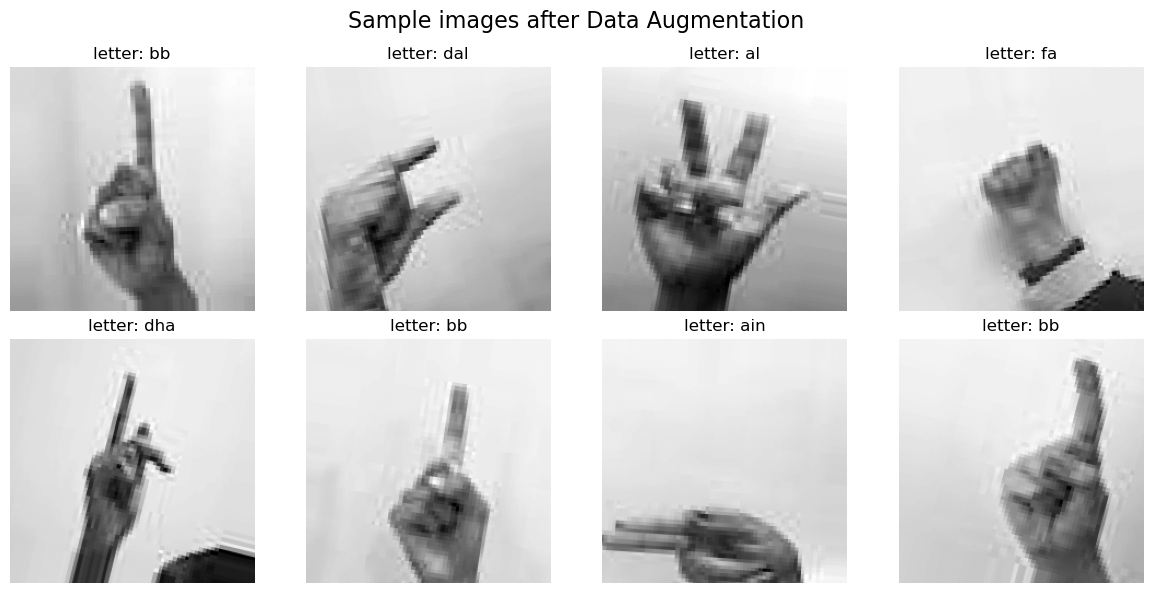

In [31]:
def show_augmented_samples():
    """Display sample images after augmentation (train generator)."""
    images, labels = next(train_generator)  # take one batch
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Sample images after Data Augmentation', fontsize=16)
    for i in range(8):
        r, c = divmod(i, 4)
        axes[r, c].imshow(images[i].squeeze(), cmap='gray')  # squeeze للقناة الوحيدة
        class_idx = np.argmax(labels[i])
        class_name = list(train_generator.class_indices.keys())[class_idx]
        axes[r, c].set_title(f'letter: {class_name}')
        axes[r, c].axis('off')
    plt.tight_layout()
    plt.show()
    train_generator.reset()  # يرجّع المؤشر للبداية

show_augmented_samples()


^^^^
وش سويت:
دالة تاخذ مجموعة صور وتعرضها
ليه:

التأكد البصري: أشوف الصور كيف صارت بعد المعالجة
اكتشاف المشاكل: لو الصور مشوهة أو التصنيف خطأ
فهم البيانات: أشوف جودة Data Augmentation

Show a sample of the images after processing

In [17]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print("\nData Pipeline setup successful!")
print(f"num_classes: {num_classes}, IMG_SIZE: {IMG_SIZE}")


Data Pipeline setup successful!
num_classes: 32, IMG_SIZE: 224


^^^^^
وش سويت:
حفظت معلومات مهمة في متغيرات
ليه:

للنموذج: راح يحتاج num_classes علشان يعرف كم حرف يتوقع
للتقييم: بنحتاج class_names علشان نفهم النتائج
للاستخدام اللاحق: في التطبيق النهائي